In [1]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import re


def parse_buildmodel_diff_file(diff_file):
    """
    Parse FoldX BuildModel Dif_*.fxout file (tab-delimited)
    """
    try:
        with open(diff_file, 'r') as f:
            lines = f.readlines()
        
        # Find data line after the header
        for i, line in enumerate(lines):
            if 'Pdb\ttotal energy' in line:
                # Next non-empty line is the data
                for data_line in lines[i+1:]:
                    data_line = data_line.strip()
                    if data_line:
                        # Split on tabs
                        parts = data_line.split('\t')
                        
                        if len(parts) >= 2:
                            result = {
                                'pdb_name': parts[0],
                                'ddG': float(parts[1])
                            }
                            
                            # Add full energy breakdown if available
                            if len(parts) >= 23:
                                result.update({
                                    'backbone_hbond': float(parts[2]),
                                    'sidechain_hbond': float(parts[3]),
                                    'van_der_waals': float(parts[4]),
                                    'electrostatics': float(parts[5]),
                                    'solvation_polar': float(parts[6]),
                                    'solvation_hydrophobic': float(parts[7]),
                                    'vdw_clashes': float(parts[8]),
                                    'entropy_sidechain': float(parts[9]),
                                    'entropy_mainchain': float(parts[10]),
                                    'sloop_entropy': float(parts[11]),
                                    'mloop_entropy': float(parts[12]),
                                    'cis_bond': float(parts[13]),
                                    'torsional_clash': float(parts[14]),
                                    'backbone_clash': float(parts[15]),
                                    'helix_dipole': float(parts[16]),
                                    'water_bridge': float(parts[17]),
                                    'disulfide': float(parts[18]),
                                    'electrostatic_kon': float(parts[19]),
                                    'partial_covalent': float(parts[20]),
                                    'energy_ionisation': float(parts[21]),
                                    'entropy_complex': float(parts[22])
                                })
                            
                            return result
                break
        
        return None
        
    except Exception as e:
        print(f"Error parsing {diff_file}: {e}")
        return None


# Test it
test_file = "../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations/A56V/3-fold/1_0/Dif_1_0.fxout"
result = parse_buildmodel_diff_file(test_file)
print(f"Test result: {result}")

def extract_mutation_data(mutations_base_dir, output_csv):
    """
    Extract all mutation data from FoldX BuildModel results
    
    Args:
        mutations_base_dir: Base directory containing mutation results
                           (e.g., 'asibi_to_17d_mutations' or '17d_to_asibi_mutations')
        output_csv: Output CSV file path
    
    Returns:
        pd.DataFrame with all mutation data
    """
    
    print(f"Searching for Dif_*.fxout files in: {mutations_base_dir}")
    
    # Find all Dif_*.fxout files recursively
    diff_files = glob.glob(f"{mutations_base_dir}/**/Dif_*.fxout", recursive=True)
    
    print(f"Found {len(diff_files)} Dif files")
    
    if not diff_files:
        print("No files found. Check the directory path.")
        return None
    
    all_data = []
    
    for diff_file in diff_files:
        path = Path(diff_file)
        
        # Extract metadata from path structure
        # Expected: mutation_base/mutation_name/assembly_type/frame/Dif_frame.fxout
        parts = path.parts
        
        try:
            # Find indices (working backwards from file)
            file_idx = len(parts) - 1
            frame_dir = parts[file_idx - 1]  # e.g., '2_5'
            assembly_type = parts[file_idx - 2]  # e.g., '5-fold'
            mutation_name = parts[file_idx - 3]  # e.g., 'A407V'
            
            # Parse the energy data
            energy_data = parse_buildmodel_diff_file(diff_file)
            
            if energy_data is None:
                continue
            
            # Combine metadata and energy data
            record = {
                'mutation': mutation_name,
                'assembly_type': assembly_type,
                'frame': frame_dir,
                'source_file': str(path),
                **energy_data
            }
            
            all_data.append(record)
            
        except IndexError:
            print(f"Warning: Could not parse path structure for {diff_file}")
            continue
    
    if not all_data:
        print("No valid data extracted")
        return None
    
    # Create DataFrame
    df = pd.DataFrame(all_data)
    
    # Add some derived columns for convenience
    df['assembly_type_clean'] = df['assembly_type'].str.replace('-', '_')
    
    # Add position extraction and sorting
    def extract_position(mutation):
        """Extract position from mutation (e.g., 'G52R' → 52)"""
        match = re.search(r'\d+', mutation)
        return int(match.group()) if match else None
    
    df['position'] = df['mutation'].apply(extract_position)
    
    # Sort by position first, then assembly type, then frame
    df = df.sort_values(['position', 'assembly_type', 'frame']).reset_index(drop=True)
    
    # Save to CSV
    df.to_csv(output_csv, index=False)
    
    print(f"\n✓ Saved {len(df)} records to: {output_csv}")
    print(f"\nSummary:")
    print(f"  Mutations: {df['mutation'].nunique()}")
    print(f"  Assembly types: {df['assembly_type'].unique()}")
    print(f"  Frames per mutation/assembly: {df.groupby(['mutation', 'assembly_type']).size().min()}-{df.groupby(['mutation', 'assembly_type']).size().max()}")
    print(f"\nΔΔG statistics:")
    print(df['ddG'].describe())
    
    return df


Test result: {'pdb_name': '1_0_1.pdb', 'ddG': -0.108995, 'backbone_hbond': -0.0691071, 'sidechain_hbond': 0.0674602, 'van_der_waals': -5.38044, 'electrostatics': 1.1701, 'solvation_polar': 4.69252, 'solvation_hydrophobic': -9.19423, 'vdw_clashes': 5.54591, 'entropy_sidechain': 2.94309, 'entropy_mainchain': -0.0275599, 'sloop_entropy': 0.0, 'mloop_entropy': 0.0, 'cis_bond': 0.0, 'torsional_clash': 0.147143, 'backbone_clash': 0.341362, 'helix_dipole': 0.0, 'water_bridge': 0.0, 'disulfide': 0.0, 'electrostatic_kon': -0.00387515, 'partial_covalent': 0.0, 'energy_ionisation': 0.0, 'entropy_complex': 0.0}


In [2]:
# ========================================
# PROCESS BOTH MUTATION DIRECTIONS
# ========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Process Asibi → 17D mutations
print("="*70)
print("PROCESSING: Asibi → 17D mutations")
print("="*70)
asibi_to_17d_dir = "../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations"
asibi_to_17d_csv = "../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations_raw.csv"
df_asibi_to_17d = extract_mutation_data(asibi_to_17d_dir, asibi_to_17d_csv)

# Process 17D → Asibi mutations
print("\n" + "="*70)
print("PROCESSING: 17D → Asibi mutations (reverse)")
print("="*70)
dir_17d_to_asibi = "../17d/viral_assembly_pipeline_results/17d_to_asibi_mutations"
csv_17d_to_asibi = "../17d/viral_assembly_pipeline_results/17d_to_asibi_mutations_raw.csv"
df_17d_to_asibi = extract_mutation_data(dir_17d_to_asibi, csv_17d_to_asibi)


PROCESSING: Asibi → 17D mutations
Searching for Dif_*.fxout files in: ../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations
Found 1080 Dif files

✓ Saved 1080 records to: ../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations_raw.csv

Summary:
  Mutations: 12
  Assembly types: ['3-fold' '5-fold' 'dimer' 'dimer_para' 'dimer_perp']
  Frames per mutation/assembly: 18-18

ΔΔG statistics:
count    1080.000000
mean        2.748723
std        13.223023
min       -19.614600
25%        -1.406110
50%         0.680330
75%         3.672703
max       203.148000
Name: ddG, dtype: float64

PROCESSING: 17D → Asibi mutations (reverse)
Searching for Dif_*.fxout files in: ../17d/viral_assembly_pipeline_results/17d_to_asibi_mutations
Found 1080 Dif files

✓ Saved 1080 records to: ../17d/viral_assembly_pipeline_results/17d_to_asibi_mutations_raw.csv

Summary:
  Mutations: 12
  Assembly types: ['3-fold' '5-fold' 'dimer' 'dimer_para' 'dimer_perp']
  Frames per mutation/assembly: 18-18

ΔΔG

✓ Saved: mutation_ddg_3_fold.png


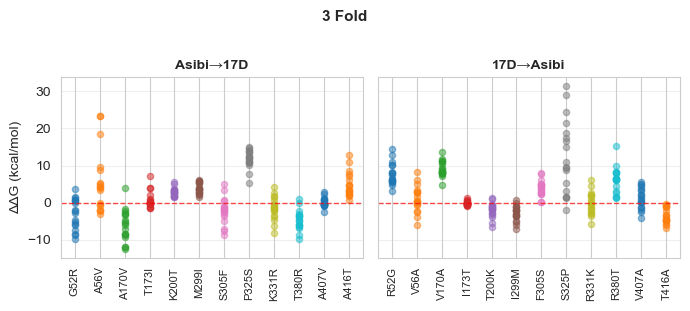

✓ Saved: mutation_ddg_5_fold.png


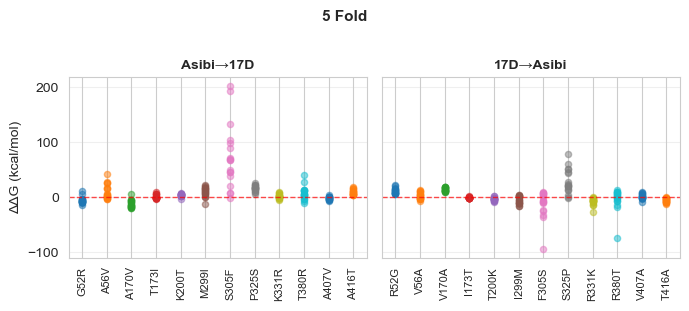

✓ Saved: mutation_ddg_dimer.png


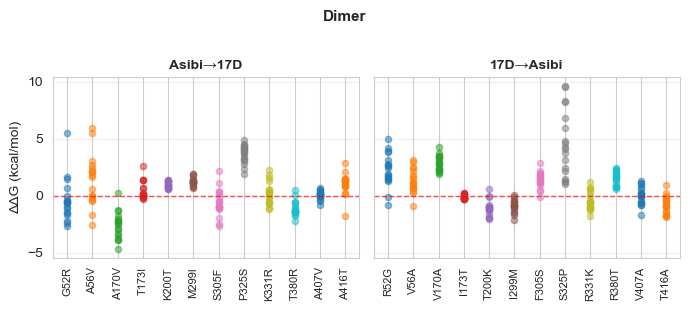

✓ Saved: mutation_ddg_dimer_para.png


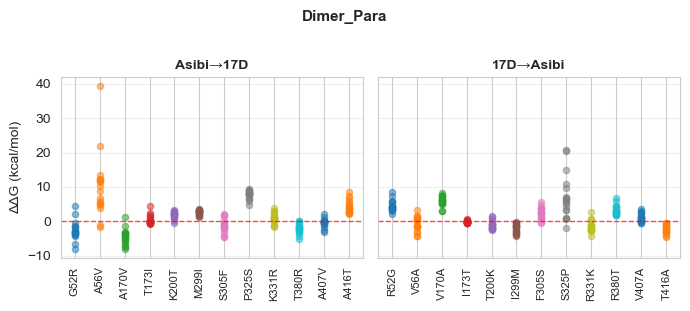

✓ Saved: mutation_ddg_dimer_perp.png


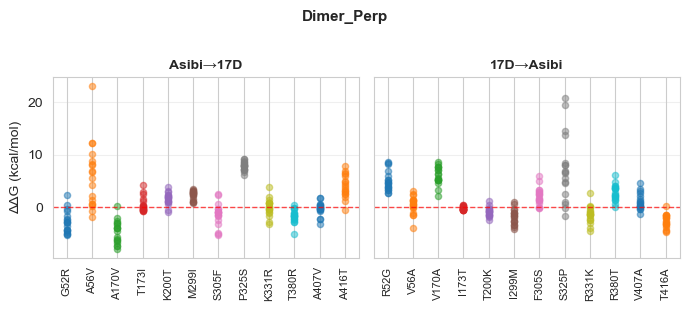


✓ All plots saved


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load data
df_asibi = pd.read_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations_raw.csv")
df_17d = pd.read_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_mutations_raw.csv")

# Get unique assembly types
assembly_types = sorted(df_asibi['assembly_type'].unique())

# Plot settings
sns.set_style("whitegrid")
single_col_width = 3.5  # inches
double_col_width = 7.0  # inches

for assembly in assembly_types:
    # Filter data
    data_asibi = df_asibi[df_asibi['assembly_type'] == assembly]
    data_17d = df_17d[df_17d['assembly_type'] == assembly]
    
    # Create figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(double_col_width, 3), sharey=True)
    
    # Left: Asibi → 17D
    ax = axes[0]
    mutations_asibi = data_asibi['mutation'].unique().tolist()
    for mut in mutations_asibi:
        mut_data = data_asibi[data_asibi['mutation'] == mut]['ddG']
        x = [mutations_asibi.index(mut)] * len(mut_data)
        ax.scatter(x, mut_data, alpha=0.5, s=20)
    
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xticks(range(len(mutations_asibi)))
    ax.set_xticklabels(mutations_asibi, rotation=90, fontsize=8)
    ax.set_ylabel('ΔΔG (kcal/mol)', fontsize=10)
    ax.set_title(f'Asibi→17D', fontsize=10, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Right: 17D → Asibi
    ax = axes[1]
    mutations_17d = data_17d['mutation'].unique().tolist()
    for mut in mutations_17d:
        mut_data = data_17d[data_17d['mutation'] == mut]['ddG']
        x = [mutations_17d.index(mut)] * len(mut_data)
        ax.scatter(x, mut_data, alpha=0.5, s=20)
    
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xticks(range(len(mutations_17d)))
    ax.set_xticklabels(mutations_17d, rotation=90, fontsize=8)
    ax.set_title(f'17D→Asibi', fontsize=10, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Overall title
    fig.suptitle(f'{assembly.replace("-", " ").title()}', fontsize=11, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    print(f"✓ Saved: mutation_ddg_{assembly.replace('-', '_')}.png")
    plt.show()
    plt.close()

print("\n✓ All plots saved")

✓ Saved: mutation_ddg_mean_3_fold.png


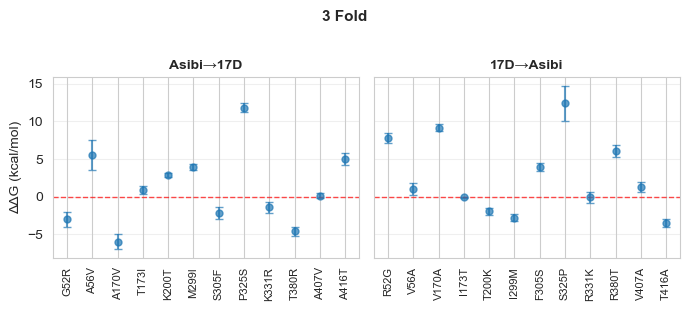

✓ Saved: mutation_ddg_mean_5_fold.png


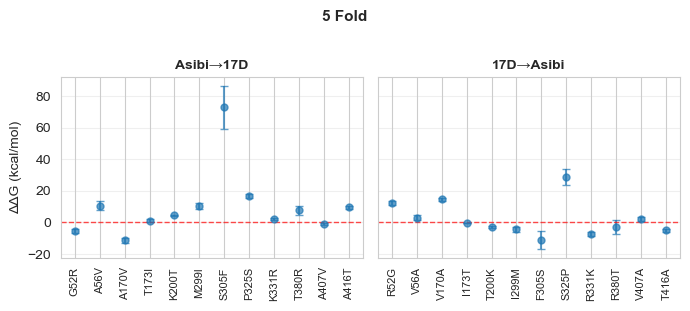

✓ Saved: mutation_ddg_mean_dimer.png


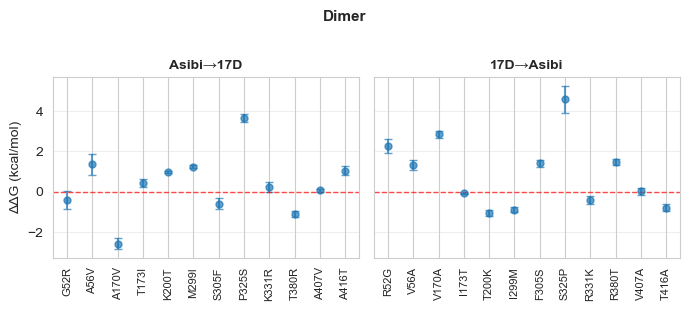

✓ Saved: mutation_ddg_mean_dimer_para.png


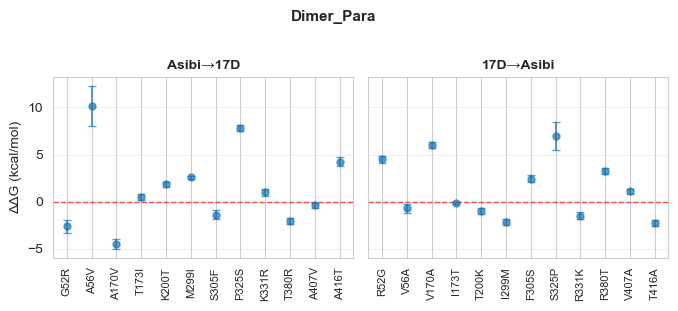

✓ Saved: mutation_ddg_mean_dimer_perp.png


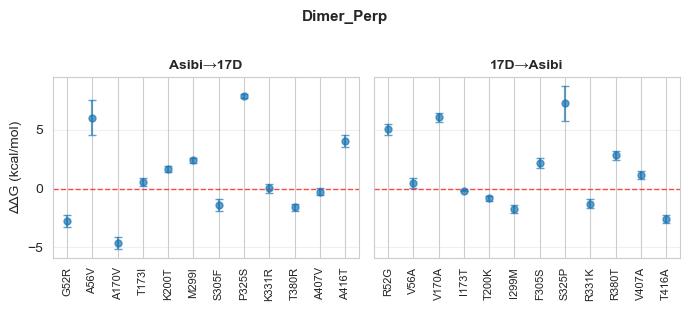

In [4]:
# Alternative with mean ± std
for assembly in assembly_types:
    data_asibi = df_asibi[df_asibi['assembly_type'] == assembly]
    data_17d = df_17d[df_17d['assembly_type'] == assembly]
    
    fig, axes = plt.subplots(1, 2, figsize=(double_col_width, 3), sharey=True)
    
    # Asibi → 17D
    ax = axes[0]
    mutations_asibi = data_asibi['mutation'].unique().tolist()
    summary = data_asibi.groupby('mutation')['ddG'].agg(['mean', 'std', 'count']).reindex(mutations_asibi)
    summary['sem'] = summary['std'] / np.sqrt(summary['count'])

    ax.errorbar(range(len(mutations_asibi)), summary['mean'], yerr=summary['sem'],
                fmt='o', capsize=3, capthick=1, markersize=5, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xticks(range(len(mutations_asibi)))
    ax.set_xticklabels(mutations_asibi, rotation=90, fontsize=8)
    ax.set_ylabel('ΔΔG (kcal/mol)', fontsize=10)
    ax.set_title('Asibi→17D', fontsize=10, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # 17D → Asibi
    ax = axes[1]
    mutations_17d = data_17d['mutation'].unique().tolist()
    summary = data_17d.groupby('mutation')['ddG'].agg(['mean', 'std', 'count']).reindex(mutations_17d)
    summary['sem'] = summary['std'] / np.sqrt(summary['count'])
    
    ax.errorbar(range(len(mutations_17d)), summary['mean'], yerr=summary['sem'],
                fmt='o', capsize=3, capthick=1, markersize=5, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xticks(range(len(mutations_17d)))
    ax.set_xticklabels(mutations_17d, rotation=90, fontsize=8)
    ax.set_title('17D→Asibi', fontsize=10, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle(f'{assembly.replace("-", " ").title()}', fontsize=11, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    print(f"✓ Saved: mutation_ddg_mean_{assembly.replace('-', '_')}.png")
    plt.show()
    plt.close()

In [5]:
# ========================================
# STEP 1: FRAME AVERAGING
# ========================================
import pandas as pd
import numpy as np

def calculate_frame_average(df_raw):
    """Calculate mean and SEM across frames for each mutation/assembly"""
    stats = df_raw.groupby(['mutation', 'assembly_type'], sort=False).agg({
        'ddG': ['mean', 'std', 'count']
    }).reset_index()
    
    stats.columns = ['mutation', 'assembly_type', 'ddG_mean', 'ddG_std', 'n_frames']
    stats['ddG_sem'] = stats['ddG_std'] / np.sqrt(stats['n_frames'])
    
    return stats

# Process both datasets
df_asibi_raw = pd.read_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_mutations_raw.csv")
df_17d_raw = pd.read_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_mutations_raw.csv")

asibi_avg = calculate_frame_average(df_asibi_raw)
df_17d_avg = calculate_frame_average(df_17d_raw)

# Save
asibi_avg.to_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_frame_averaged.csv", index=False)
df_17d_avg.to_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_frame_averaged.csv", index=False)

print("✓ Frame averaging complete")
print(f"  Asibi→17D: {len(asibi_avg)} mutation/assembly combinations")
print(f"  17D→Asibi: {len(df_17d_avg)} mutation/assembly combinations")

✓ Frame averaging complete
  Asibi→17D: 60 mutation/assembly combinations
  17D→Asibi: 60 mutation/assembly combinations


In [6]:
# ========================================
# STEP 2: INTERFACE CONTRIBUTIONS
# ========================================

def calculate_interface_contributions(df_avg):
    """Calculate interface-specific contributions by subtracting dimer baseline"""
    
    # Pivot to get one row per mutation with columns for each assembly
    pivot = df_avg.pivot_table(
        index='mutation',
        columns='assembly_type',
        values=['ddG_mean', 'ddG_std', 'ddG_sem', 'n_frames'],
        sort=False
    )
    
    # Flatten column names
    pivot.columns = ['_'.join(col).strip() for col in pivot.columns.values]
    pivot = pivot.reset_index()
    
    # Calculate interface contributions (subtract dimer)
    pivot['vertex_5fold'] = pivot['ddG_mean_5-fold'] - 5 * pivot['ddG_mean_dimer']
    pivot['vertex_3fold'] = pivot['ddG_mean_3-fold'] - 3 * pivot['ddG_mean_dimer']
    pivot['inter_dimer_para'] = pivot['ddG_mean_dimer_para'] - 2 * pivot['ddG_mean_dimer']
    pivot['inter_dimer_perp'] = pivot['ddG_mean_dimer_perp'] - 2 * pivot['ddG_mean_dimer']
    
    # Error propagation: σ²_interface = σ²_assembly + n²×σ²_dimer
    pivot['vertex_5fold_sem'] = np.sqrt(
        pivot['ddG_sem_5-fold']**2 + 25 * pivot['ddG_sem_dimer']**2
    )
    pivot['vertex_3fold_sem'] = np.sqrt(
        pivot['ddG_sem_3-fold']**2 + 9 * pivot['ddG_sem_dimer']**2
    )
    pivot['inter_dimer_para_sem'] = np.sqrt(
        pivot['ddG_sem_dimer_para']**2 + 4 * pivot['ddG_sem_dimer']**2
    )
    pivot['inter_dimer_perp_sem'] = np.sqrt(
        pivot['ddG_sem_dimer_perp']**2 + 4 * pivot['ddG_sem_dimer']**2
    )
    
    return pivot

asibi_interfaces = calculate_interface_contributions(asibi_avg)
df_17d_interfaces = calculate_interface_contributions(df_17d_avg)

# Save
asibi_interfaces.to_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_interfaces.csv", index=False)
df_17d_interfaces.to_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_interfaces.csv", index=False)

print("✓ Interface contributions calculated")
print(f"\nAsibi→17D interface contributions:")
print(asibi_interfaces[['mutation', 'vertex_5fold', 'vertex_3fold']].head())

✓ Interface contributions calculated

Asibi→17D interface contributions:
  mutation  vertex_5fold  vertex_3fold
0     G52R     -3.454282     -1.808219
1     A56V      3.918254      1.435996
2    A170V      1.655357      1.764377
3    T173I     -1.026824     -0.479219
4    K200T     -0.413966     -0.025214


In [7]:
# ========================================
# STEP 3: VIRAL CAPSID CONTRIBUTION
# ========================================

def calculate_viral_capsid(df_interfaces):
    """Calculate total viral capsid contribution using raw assembly values"""
    
    df = df_interfaces.copy()
    
    # Total ΔΔG using algebraic expansion (net dimer coefficient = -270)
    df['ddG_capsid'] = (
        12 * df['ddG_mean_5-fold'] +
        20 * df['ddG_mean_3-fold'] +
        60 * df['ddG_mean_dimer_para'] +
        60 * df['ddG_mean_dimer_perp'] +
        (-270) * df['ddG_mean_dimer']
    )
    
    # Error propagation using raw assembly values
    df['ddG_capsid_sem'] = np.sqrt(
        144 * df['ddG_sem_5-fold']**2 +
        400 * df['ddG_sem_3-fold']**2 +
        3600 * df['ddG_sem_dimer_para']**2 +
        3600 * df['ddG_sem_dimer_perp']**2 +
        72900 * df['ddG_sem_dimer']**2
    )
    
    # Also include interface-weighted sum for interpretation
    df['ddG_capsid_interfaces'] = (
        12 * df['vertex_5fold'] +
        20 * df['vertex_3fold'] +
        60 * df['inter_dimer_para'] +
        60 * df['inter_dimer_perp'] +
        90 * df['ddG_mean_dimer']
    )
    
    return df

asibi_capsid = calculate_viral_capsid(asibi_interfaces)
df_17d_capsid = calculate_viral_capsid(df_17d_interfaces)

# Save
asibi_capsid.to_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_capsid.csv", index=False)
df_17d_capsid.to_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_capsid.csv", index=False)

print("✓ Viral capsid contributions calculated")
print(f"\nAsibi→17D top 5 capsid stabilizers:")
top5 = asibi_capsid.nlargest(5, 'ddG_capsid')[['mutation', 'ddG_capsid', 'ddG_capsid_sem']]
print(top5.to_string(index=False))

print(f"\nAsibi→17D top 5 capsid destabilizers:")
bottom5 = asibi_capsid.nsmallest(5, 'ddG_capsid')[['mutation', 'ddG_capsid', 'ddG_capsid_sem']]
print(bottom5.to_string(index=False))

✓ Viral capsid contributions calculated

Asibi→17D top 5 capsid stabilizers:
mutation  ddG_capsid  ddG_capsid_sem
    A56V  843.817149      217.310864
   S305F  828.935815      186.070492
   A416T  429.739906       74.192335
   P325S  388.941866       56.729065
   M299I  168.554734       36.675726

Asibi→17D top 5 capsid destabilizers:
mutation  ddG_capsid  ddG_capsid_sem
    G52R -339.169055      132.499522
   A170V -106.726942       90.741109
   A407V  -68.459915       34.771671
   T173I  -25.648421       57.929473
   K331R   -5.631189       72.094178


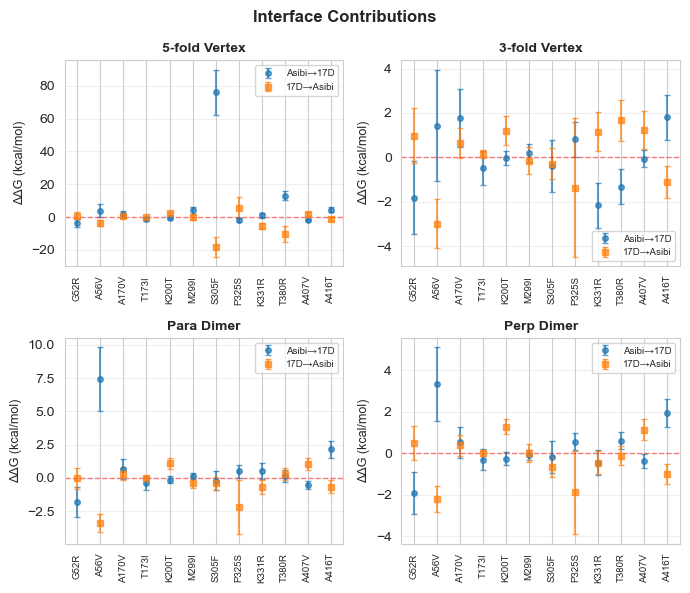

In [17]:
# ========================================
# VISUALIZATION: INTERFACE CONTRIBUTIONS
# ========================================
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
fig.suptitle('Interface Contributions', fontsize=12, fontweight='bold')

interfaces = ['vertex_5fold', 'vertex_3fold', 'inter_dimer_para', 'inter_dimer_perp']
titles = ['5-fold Vertex', '3-fold Vertex', 'Para Dimer', 'Perp Dimer']

for idx, (interface, title) in enumerate(zip(interfaces, titles)):
    ax = axes.flat[idx]
    
    mutations = asibi_capsid['mutation'].values
    x = np.arange(len(mutations))
    
    # Asibi → 17D
    y_asibi = asibi_capsid[interface].values
    yerr_asibi = asibi_capsid[f'{interface}_sem'].values
    ax.errorbar(x, y_asibi, yerr=yerr_asibi, fmt='o', capsize=2, 
                markersize=4, label='Asibi→17D', alpha=0.7)
    
    # 17D → Asibi
    y_17d = df_17d_capsid[interface].values
    yerr_17d = df_17d_capsid[f'{interface}_sem'].values
    ax.errorbar(x, y_17d, yerr=yerr_17d, fmt='s', capsize=2,
                markersize=4, label='17D→Asibi', alpha=0.7)
    
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(mutations, rotation=90, fontsize=7)
    ax.set_ylabel('ΔΔG (kcal/mol)', fontsize=9)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.legend(fontsize=7)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

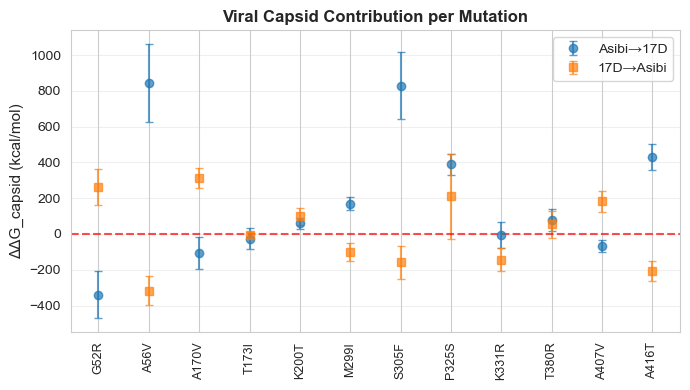

In [25]:
# ========================================
# VISUALIZATION: VIRAL CAPSID COMPARISON
# ========================================

fig, ax = plt.subplots(figsize=(7, 4))

mutations = asibi_capsid['mutation'].values
x = np.arange(len(mutations))

# Asibi → 17D
y_asibi = asibi_capsid['ddG_capsid'].values
yerr_asibi = asibi_capsid['ddG_capsid_sem'].values
ax.errorbar(x, y_asibi, yerr=yerr_asibi, fmt='o', capsize=3,
            markersize=6, label='Asibi→17D', alpha=0.7)

# 17D → Asibi
y_17d = df_17d_capsid['ddG_capsid'].values
yerr_17d = df_17d_capsid['ddG_capsid_sem'].values
ax.errorbar(x, y_17d, yerr=yerr_17d, fmt='s', capsize=3,
            markersize=6, label='17D→Asibi', alpha=0.7)

ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(mutations, rotation=90, fontsize=9)
ax.set_ylabel('ΔΔG_capsid (kcal/mol)', fontsize=11)
ax.set_title('Viral Capsid Contribution per Mutation', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

plt.show()

In [12]:
# ========================================
# INTERACTIVE MUTATION VISUALIZATION (FIXED)
# ========================================
import ipywidgets as widgets
from IPython.display import display
import nglview as nv
from Bio.PDB import PDBParser, PDBIO
import pandas as pd
import numpy as np
import glob

# Load data
asibi_avg = pd.read_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_frame_averaged.csv")
df_17d_avg = pd.read_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_frame_averaged.csv")
asibi_capsid = pd.read_csv("../asibi/viral_assembly_pipeline_results/asibi_to_17d_capsid.csv")
df_17d_capsid = pd.read_csv("../17d/viral_assembly_pipeline_results/17d_to_asibi_capsid.csv")

# Add position column if needed
def extract_position(mutation):
    import re
    match = re.search(r'\d+', mutation)
    return int(match.group()) if match else None

if 'position' not in asibi_capsid.columns:
    asibi_capsid['position'] = asibi_capsid['mutation'].apply(extract_position)
if 'position' not in df_17d_capsid.columns:
    df_17d_capsid['position'] = df_17d_capsid['mutation'].apply(extract_position)


# Find templates from both systems
asibi_templates = {}
for assembly in ['3-fold', '5-fold', 'dimer', 'dimer_para', 'dimer_perp']:
    files = glob.glob(f"../asibi/viral_assembly_pipeline_results/assembly-foldx_optimized/{assembly}/*.pdb")
    for f in files:
        frame = f.split('/')[-1].replace('.pdb', '')
        asibi_templates[f"{assembly}/{frame}"] = f

df_17d_templates = {}
for assembly in ['3-fold', '5-fold', 'dimer', 'dimer_para', 'dimer_perp']:
    files = glob.glob(f"../17d/viral_assembly_pipeline_results/assembly-foldx_optimized/{assembly}/*.pdb")
    for f in files:
        frame = f.split('/')[-1].replace('.pdb', '')
        df_17d_templates[f"{assembly}/{frame}"] = f

template_dropdown = widgets.Dropdown(
    options=list(asibi_templates.keys()),
    value='3-fold/0_0' if '3-fold/0_0' in asibi_templates else list(asibi_templates.keys())[0],
    description='Template:',
)

def update_direction(change=None):
    """Update template options when direction changes"""
    if direction_dropdown.value == 'Asibi→17D':
        template_dropdown.options = list(asibi_templates.keys())
    else:
        template_dropdown.options = list(df_17d_templates.keys())
    template_dropdown.value = template_dropdown.options[0]
    update_view()


MODES = {
    'Per-Assembly': {
        'use_capsid': False,
        'assemblies': ['3-fold', '5-fold', 'dimer', 'dimer_para', 'dimer_perp'],
    },
    'Interface Contribution': {
        'use_capsid': True,
        'assemblies': ['vertex_5fold', 'vertex_3fold', 'inter_dimer_para', 'inter_dimer_perp'],
    },
    'Viral Capsid': {
        'use_capsid': True,
        'assemblies': ['capsid'],
    }
}

# Widgets
direction_dropdown = widgets.Dropdown(
    options=['Asibi→17D', '17D→Asibi'],
    value='Asibi→17D',
    description='Direction:',
)

mode_dropdown = widgets.Dropdown(
    options=list(MODES.keys()),
    value='Viral Capsid',
    description='Mode:',
)

assembly_dropdown = widgets.Dropdown(
    options=MODES['Viral Capsid']['assemblies'],
    value='capsid',
    description='View:',
)


steepness_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=1000.0,
    step=0.1,
    description='Steepness:',
    continuous_update=False,
)

view_widget = widgets.Output()

def update_mode(change=None):
    mode_config = MODES[mode_dropdown.value]
    assembly_dropdown.options = mode_config['assemblies']
    assembly_dropdown.value = mode_config['assemblies'][0]
    assembly_dropdown.disabled = len(mode_config['assemblies']) == 1
    update_view()

def update_view(change=None):
    with view_widget:
        view_widget.clear_output(wait=True)
        
        direction = direction_dropdown.value
        mode = mode_dropdown.value
        mode_config = MODES[mode]
        assembly = assembly_dropdown.value
        steepness = steepness_slider.value
        # Get template from correct system
        if direction == 'Asibi→17D':
            template = asibi_templates[template_dropdown.value]
        else:
            template = df_17d_templates[template_dropdown.value]
        
        # Get data
        if direction == 'Asibi→17D':
            df_avg_data = asibi_avg
            df_capsid_data = asibi_capsid
        else:
            df_avg_data = df_17d_avg
            df_capsid_data = df_17d_capsid
        
        # Get values for mutated positions
        position_values = {}
        
        if mode == 'Per-Assembly':
            data = df_avg_data[df_avg_data['assembly_type'] == assembly]
            for _, row in data.iterrows():
                pos = extract_position(row['mutation'])
                position_values[pos] = row['ddG_mean']
        elif mode == 'Interface Contribution':
            for _, row in df_capsid_data.iterrows():
                pos = row['position']
                position_values[pos] = row[assembly]
        else:  # Viral Capsid
            for _, row in df_capsid_data.iterrows():
                pos = row['position']
                position_values[pos] = row['ddG_capsid']
        
        # Color scale
        values = list(position_values.values())
        
        vmin = -steepness
        vmax = steepness
        # to center around the median
        if  0:
            median = np.median(values)
            vmin = median - steepness
            vmax = median + steepness
        
        print(f"{direction} - {mode}")
        if mode != 'Viral Capsid':
            print(f"  View: {assembly}")
        print(f"  Template: {template_dropdown.value}")
        print(f"  Mutated positions: {len(position_values)}")
        print(f"  ΔΔG range: [{min(values):.2f}, {max(values):.2f}]")
        print(f"  Color: [{vmin:.2f}, {vmax:.2f}]")
        
        # After loading structure:
        EXCLUDE_CHAINS = {'C', 'D', 'G', 'H', 'K', 'L', 'O', 'P', 'S', 'T'}

        # Load structure and set B-factors
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('protein', template)

        for model in structure:
            for chain in model:
                if chain.id in EXCLUDE_CHAINS:
                    continue
                for residue in chain:
                    if residue.id[0] == ' ':
                        res_num = residue.id[1]
                        bfactor = position_values.get(res_num, 0)
                        for atom in residue:
                            atom.set_bfactor(bfactor)

        # Save
        temp_pdb = f"/tmp/mutation_viz.pdb"
        io = PDBIO()
        io.set_structure(structure)
        io.save(temp_pdb)

        # Visualize
        view = nv.show_structure_file(temp_pdb)
        view.clear_representations()

        # Create chain selection
        included_chains = [c for c in 'ABEFIJMNQRU' if c not in EXCLUDE_CHAINS]
        chain_selection = ' or '.join([f':{c}' for c in included_chains])

        view.add_representation('cartoon', 
                                selection=chain_selection,
                                color_scheme='bfactor',
                                color_scale='rwb',
                                color_domain=[vmax, vmin])

        # Highlight mutated positions
        for pos in position_values.keys():
            view.add_representation('spacefill', 
                                    selection=f'{pos} and ({chain_selection})',
                                    color_scheme='bfactor',
                                    color_scale='rwb',
                                    color_domain=[vmax, vmin],
                                    opacity=0.8)
    
        view.center()
        display(view)

# Connect
direction_dropdown.observe(update_direction, names='value')
mode_dropdown.observe(update_mode, names='value')
assembly_dropdown.observe(update_view, names='value')
template_dropdown.observe(update_view, names='value')
steepness_slider.observe(update_view, names='value')

# Display
controls = widgets.VBox([
    direction_dropdown,
    mode_dropdown,
    assembly_dropdown,
    template_dropdown,
    steepness_slider
])

display(controls)
display(view_widget)
update_view()

Output()